<h1>1. AR, MA, ARIMA Examples</h1> 
<hr>
<h2>Overview</h2>
This notebook is designed to explore some popular examples of univariate timeseries modelling techniques in the ARMA family. It explores the following model types:<br><br>
- Autoregrssive (AR)<br>
- Moving Average (MA)<br>
- Autoregressive Integreated Moving Average (ARIMA)<br><br>
The data used is immaterial to the purpose of the notebook, but for consistency's sake the **macrodata** dataset from the statsmodels package is used throughout. The dependent variable used for all models is realgdp.<br><br>
<h2>Contents</h2>
1.0) Install Packages / Download Dataset<br>
1.1) Exploring Dataset & Ensuring Stationarity<br>
1.2) AR Model<br>
1.3) MA Model<br>
1.4) ARIMA Model<br>
<h2>1.0) Install Packages / Download Dataset</h2>

In [20]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid
from scipy.stats import gaussian_kde
from statsmodels.tsa.stattools import adfuller
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.arima.model import ARIMA
data = sm.datasets.macrodata.load_pandas().data
data[['year', 'quarter']].head()


,year,quarter
0,1959.0,1.0
1,1959.0,2.0
2,1959.0,3.0
3,1959.0,4.0
4,1960.0,1.0


<h2>1.1) Exploring Dataset & Ensuring Stationarity</h2>
The models explored in this notebook are univariate, so this section will only explore the dependent variable.<br><br>

In [2]:
data['realgdp'].describe()

count      203.000000
mean      7221.171901
std       3214.956044
min       2710.349000
25%       4440.103500
50%       6559.594000
75%       9629.346500
max      13415.266000
Name: realgdp, dtype: float64

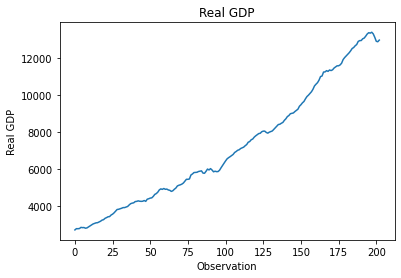

In [3]:
plt.plot(data.index, data['realgdp'])
plt.title("Real GDP")
plt.xlabel("Observation")
plt.ylabel("Real GDP")
plt.show()

Initial observations are that over the 200+ observations generally increase over time and therefore the time series does not appear stationary. The models in this notebook presuppose stationary data, and therefore differencing will be applied in an effort to make data stationary. 

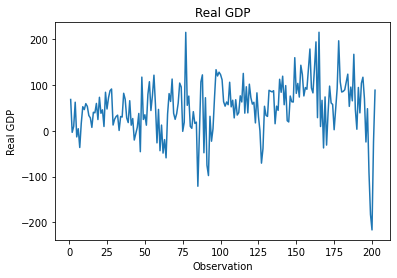

In [4]:
data['realgdp_diff'] = data['realgdp'].diff()
timeseries = data['realgdp_diff'].dropna()

plt.plot(timeseries.index, timeseries)
plt.title("Real GDP")
plt.xlabel("Observation")
plt.ylabel("Real GDP")
plt.show()

Visually, this timeseries appears to 'more stationary' than the un-differenced version. Indeed, by looking at the histograms below of the values from each time series, it is clear that the differenced values are 'more normally distributed'. 

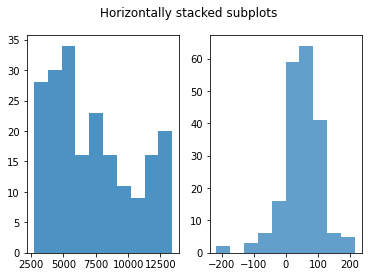

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Horizontally stacked subplots')
ax1.hist(data['realgdp'], label='series1', alpha=0.8)
ax2.hist(timeseries, label='series2', alpha=0.7)

plt.show()

This visual approach is not without merit, but in the interest of rigour, an Augmented Dicky Fuller (ADF) test (from statsmodels) will also be applied to look for stationarity. The null hypothesis (H0) of the ADF test is that a unit root exists and therefore the time series is not stationary. The alternate hypothesis (H1) is that a unit root does not exist and therefore the timeseries is stationary.

In [6]:
adf_result = adfuller(timeseries)
print('Test Statistic: %6f' % adf_result[0])
print('p-value: %6f' % adf_result[1])
print('Critical Values:')
for key, value in adf_result[4].items():
    print('\t%s: %.3f' % (key, value))

Test Statistic: -6.305696
p-value: 0.000000
Critical Values:
	1%: -3.463
	5%: -2.876
	10%: -2.575


The p-value is 0 to six significant figures and the ADF test confirms the visual observation that the data is stationary. Therefore, this differenced dataset will be used as the dependent variable going forward. The final step is to split the data into training and test data, which will be done on an 80/20 ratio.

In [7]:
split_idx = round(len(timeseries) * 0.8)
train = data['realgdp'].iloc[:split_idx]
test = data['realgdp'].iloc[split_idx:]

<h2>1.2) AR Model</h2>
The AR model is a univariate model that presupposes that datapoints in a timeseries are lineraly dependent on the preceeding datapoints. The AR model formula is below, where dependent variable y is a function of past values of y, multiplied by constants phi, plus an error term. <br><br>
$$ y_t = \phi_1 y_{t-1} + \phi_2 y_{t-2} + \ldots + \phi_p y_{t-p} + \varepsilon_t
$$
<br><br> The only hyperparameter that requires tuning is the order of ther model (p) which represents the number of lags included in the model, and there are tyipcally two ways to do that. The first is to use a Partial Autocorrelation Function (PACF), which looks at the level of correlation with previous datapoints, controlling for others lags. An alternative approach would be to brute force search of a given parameter space using a specific metric like AIC or MSE. The latter is preferable, provided that the computational power is availible, on account of its discrimination between alternatives being quantified. The AR model example here will use a brute force search.<br><br>
This example will also introduce the ARIMA package. ARIMA as an approach will be explored in section 5, but in the mean time we can say that the parameters (p, d, q) correspond to the the order of the AR model (p), the number of times the data is differenced (d) and the order of the MA model (q). Because we are building an AR model, in our example, q=0 meaning there is no AR component. We will use the original dataset, but not specify the level of differencing, instead exploring the parameter space d=[1, 2, 3] as well as 1 < p <=15.

{'model_obj': <statsmodels.tsa.arima.model.ARIMAResultsWrapper object at 0x7ff0f9876df0>, 'params': {'d': 2, 'p': 9}, 'AIC': 1705.678754240641}


<AxesSubplot:ylabel='Density'>

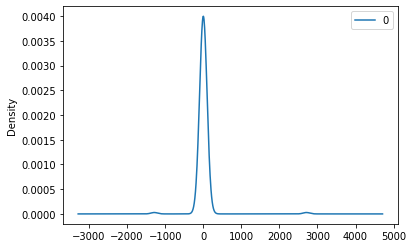

In [8]:
parameter_space = {'p': [i + 1 for i in range(10)],
                   'd':[1, 2, 3]
                   }   
        
grd_srch = list(ParameterGrid(parameter_space))

best_model = {'model_obj':'none evaluated', 'params':'none evaluated'}

for param in grd_srch:
    ar_model = ARIMA(train, order=(param['p'],param['d'],0))
    model_fit = ar_model.fit()
    
    if (best_model['model_obj'] == 'none evaluated'):
        best_model = {'model_obj':model_fit, 'params':param, 'AIC': model_fit.aic}
        
    elif best_model['model_obj'].aic > model_fit.aic:
        best_model = {'model_obj':model_fit, 'params':param, 'AIC': model_fit.aic}

print(best_model)
residuals = pd.DataFrame(best_model['model_obj'].resid)
residuals.plot(kind='kde')


The distribution of residuals on training data seems to be appropriately centered around 0, but with very long tails. Given that the p value chosen was the highest, further testing using the AR model suggests that the actual p value may be larger and that the model benefits from higher orders in this context. When using the AR model to predict, as done below, the trend is reasonably well captured, although it does fail to elegantly capture the trajectory. 

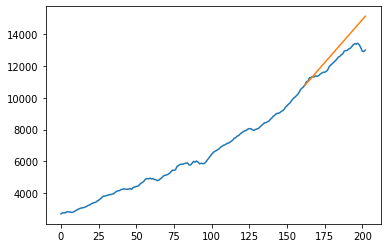

In [9]:
ar_forecast = best_model['model_obj'].predict(start=split_idx,end=len(timeseries),dynamic=True)
plt.plot(data['realgdp'])
plt.plot(ar_forecast)

<h2>1.3) MA Model</h2>
The MA model is also a univariate model, however its presupposition is that a datapoint in a time series in linearly dependent on the error terms of preceding datapoints. Similar to the AR model, there is only one hyperparameter that requires tuning, which is the order (q). The formula for the model is very similar to the AR appraoch, where instead of past values, past distances (epsilon) from the mean are used, multiplied by coefficient theta, plus an error term:<br><br>
$$ y_t = \mu + \theta_1 \varepsilon_{t-1} + \theta_2 \varepsilon_{t-2} + \ldots + \theta_q \varepsilon_{t-q} + \varepsilon_t
 $$
<br><br> For variety's sake, unlike the brute force hyperparameter seach used for AR, here we will look at the Autocorrelation Function (ACF) plot to attempt to determine q. 

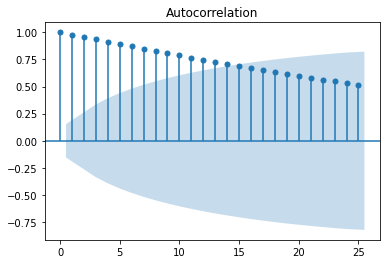

In [10]:
sm.graphics.tsa.plot_acf(train, lags=25)
plt.show()

In the ACF plot above, you can see that the 14th lag is autocorrelated and beyond the 95% conf. interval mark, making the order for the MA model a rather large q=14. 

In [30]:
ma_model = ARIMA(train, order=(0,1,14))
ma_model_fit = ma_model.fit()
print('d Parameter =', d, ' : AIC = ',ma_model_fit.aic)

d Parameter = 2  : AIC =  1723.0793780666618


d=2 produced a lower AIC, so it will be used for the final MA model. Visually, the MA model seems to predict future levels of real GDP more accurately than the AR model. Indeed, the AIC is lower.

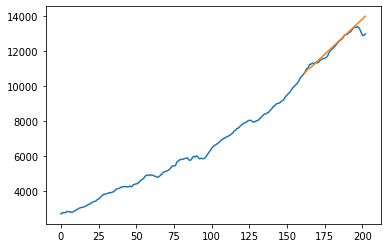

In [12]:
ma_model = ARIMA(train, order=(0,2,14))
ma_model_fit = ma_model.fit()
ma_forecast = ma_model_fit.predict(start=split_idx,end=len(timeseries),dynamic=True)
plt.plot(data['realgdp'])
plt.plot(ma_forecast)

<h2>1.4) ARIMA Model</h2>
As briefly explored above, the ARIMA model is a combination of the AR and MA models, with the I standing for "integrated", representing the differencing. Given that this is the most powerful model explored in this notebook, an exhaustive search of the parameter space will take place to ensure the best performance. In instances where this is not possible, it is possible to use the ACF and PACF approaches to determine the p and q orders. d can be determined by reaching a satisfactory level of stationarity via differencing. 

{'model_obj': <statsmodels.tsa.arima.model.ARIMAResultsWrapper object at 0x7ff0fa72b8b0>, 'params': {'d': 2, 'p': 2, 'q': 1}, 'AIC': 1694.0926829380433}


<AxesSubplot:ylabel='Density'>

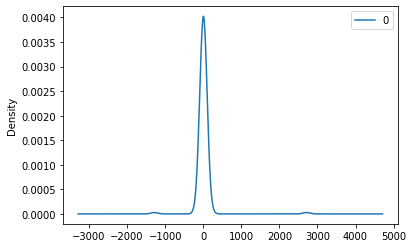

In [13]:
parameter_space = {'p': [i for i in range(3)],
                   'd':[1, 2],
                   'q': [i for i in range(3)]
                   }   
        
grd_srch = list(ParameterGrid(parameter_space))

best_arima_model = {'model_obj':'none evaluated', 'params':'none evaluated'}

for param in grd_srch:
    arima_model = ARIMA(train, order=(param['p'],param['d'],param['q']))
    model_fit = arima_model.fit()
    
    if (best_arima_model['model_obj'] == 'none evaluated'):
        best_arima_model = {'model_obj':model_fit, 'params':param, 'AIC': model_fit.aic}
        
    elif best_arima_model['model_obj'].aic > model_fit.aic:
        best_arima_model = {'model_obj':model_fit, 'params':param, 'AIC': model_fit.aic}

print(best_arima_model)
residuals = pd.DataFrame(best_arima_model['model_obj'].resid)
residuals.plot(kind='kde')

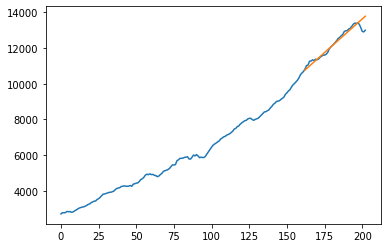

In [33]:
arima_forecast = best_arima_model['model_obj'].predict(start=split_idx,end=len(timeseries),dynamic=True)
plt.plot(data['realgdp'])
plt.plot(arima_forecast)

In [32]:
print('AR AIC:    %4f' % best_model['AIC'])
print('MA AIC:    %4f' % ma_model_fit.aic)
print('ARIMA AIC: %4f' % best_arima_model['AIC'])

AR AIC:    1705.678754
MA AIC:    1723.079378
ARIMA AIC: 1694.092683


Producing the lowest AIC, the ARIMA model is the best performing of the three. While the model fails to predict the dip at the end, it otherwise performed    quite well.